Q1.3. Which are the top 10 pizza restaurants by rating?

In [2]:
# Import required libraries
import sqlite3
import pandas as pd
import os
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import folium

from pandas.api.types import is_numeric_dtype
from folium.plugins import HeatMap
from matplotlib import colormaps
from matplotlib.colors import to_hex


# Get the directory containing the current script
current_dir = current_dir = os.getcwd()

# Construct paths relative to the current script
deliveroo_db = os.path.join(current_dir, "../databases/deliveroo.db")
takeaway_db = os.path.join(current_dir, "../databases/takeaway.db")
ubereats_db = os.path.join(current_dir, "../databases/ubereats.db")

# databases = ['../databases/deliveroo.db', '../databases/takeaway.db', '../databases/ubereats.db']

# Connect to the first database
conn = sqlite3.connect(deliveroo_db)

# Attach other databases
conn.execute(f"ATTACH DATABASE '{ubereats_db}' AS ubereats_db;")
conn.execute(f"ATTACH DATABASE '{takeaway_db}' AS takeaway_db;")

cursor = conn.cursor()

In [3]:
query1 = """SELECT DISTINCT id, name, rating FROM (SELECT DISTINCT id, name, category, rating 
            FROM restaurants 
            WHERE category LIKE '%Pizza%' OR
            category LIKE '%pizza%'
             
            UNION
            SELECT DISTINCT restaurants.id AS id, restaurants.name AS name,  categories.category, restaurants.rating__rating_value AS rating
            FROM ubereats_db.restaurants 
            JOIN ubereats_db.restaurant_to_categories AS categories ON restaurants.id == categories.restaurant_id
            WHERE categories.category LIKE '%Pizza%' OR categories.category LIKE '%pizza%'

            UNION
            SELECT DISTINCT restaurants.primarySlug AS id, restaurants.name, categories.name, restaurants.ratings AS rating 
            FROM takeaway_db.categories
            JOIN takeaway_db.categories_restaurants ON categories.restaurant_id == categories_restaurants.restaurant_id
            JOIN takeaway_db.restaurants ON categories.restaurant_id == restaurants.primarySlug
            WHERE categories.name LIKE '%Pizza%' OR
            categories.name LIKE '%pizza%')
            ORDER BY rating DESC LIMIT 10;
            """

df_pizza = pd.read_sql_query(query1, conn)
df_pizza#[['name', 'rating']]

,id,name,rating
0,eethuis-carlos-aarschot,De Echte Eethuis Carlos,5.0
1,kebap-pizza-de-brug,Kebap - Pizza De Brug,5.0
2,la-trca,La Trinacria Bottega,5.0
3,munchies-ieper,Munchies Ieper,5.0
4,snack-it,Snack-It,5.0
5,trend-kebab-pizzeria,Trend Kebab & Pizzeria,5.0
6,17478ff5-ba5d-5166-ba01-48d1f97cb588,American pizza,4.9
7,5a603fd8-4bfa-44e7-a4ad-47063893957f,Fratello's,4.9
8,am-princesse,Am Princesse,4.9
9,b0bc113f-86e9-41ed-95e1-7e8d4957ac9f,Pizza Autentica,4.9


In [4]:
fig = px.bar(df_pizza, x='name', y="rating",
               labels={"name": "Name of restaurants serving pizza", "rating": "Rating for the restaurant"}, 
              title = "Top 10 pizza restaurants by rating")
fig.show()

Q2.3. Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?

In [5]:
query2 = """SELECT count_of_restaurant, postal_code, latitude, longitude FROM (SELECT DISTINCT COUNT(name) AS count_of_restaurant, postal_code,
AVG(latitude) AS latitude, AVG(longitude) AS longitude
FROM restaurants
WHERE postal_code IS NOT NULL
GROUP BY postal_code
UNION

SELECT DISTINCT COUNT(restaurants.name) AS count_of_restaurant, locations.postalCode AS postal_code,
AVG(locations.latitude) AS latitude, AVG(locations.longitude) AS longitude
FROM takeaway_db.restaurants
JOIN takeaway_db.locations_to_restaurants ON restaurants.primarySlug == locations_to_restaurants.restaurant_id
JOIN takeaway_db.locations ON locations_to_restaurants.location_id == locations.ID
WHERE postal_code IS NOT NULL
GROUP BY postal_code
UNION
SELECT DISTINCT COUNT(restaurants.name) AS count_of_restaurant,
       restaurants.postal_code as postal_code,
       AVG(restaurants.latitude) as latitude, 
       AVG(restaurants.longitude) as longitude
FROM ubereats_db.restaurants
WHERE postal_code IS NOT NULL
GROUP BY postal_code)
WHERE count_of_restaurant < 100
ORDER BY count_of_restaurant

"""

df_deadzone = pd.read_sql_query(query2, conn)
df_deadzone.to_csv('dead_zone.csv')

In [6]:
def check_type_numeric_cols(df):
    '''
    Checks if all numeric columns are really numeric and changes them otherwise.
    It takes and returns a df.
    '''   
    numeric_columns_df =  df[["latitude", "longitude"]]


    # check the selected columns are numeric same as the one specified
    numeric_columns = df.select_dtypes(include=np.number).columns
    is_all_numeric = len(numeric_columns) == len(numeric_columns_df.columns)
    if(not is_all_numeric):
        convert_dict = { }
        for column in numeric_columns_df:
            # Select column contents by column
            columnSeriesObj = numeric_columns_df[column]
            if is_numeric_dtype(columnSeriesObj.dtype):
                convert_dict[column] = columnSeriesObj.dtype
            else:
                convert_dict[column] = np.float64
        df = df.astype(convert_dict)
    
    return df

In [7]:
average = df_deadzone['count_of_restaurant'].mean()
print(average)

23.79398148148148


In [8]:
df_deadzone = check_type_numeric_cols(df_deadzone)
df = df_deadzone.dropna(subset=['latitude', 'longitude'])

# Create a base map
#m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)
m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)  # Centered on Belgium

min_count = df['count_of_restaurant'].min()
max_count = df['count_of_restaurant'].max()

df['color'] = df['count_of_restaurant'].apply(lambda x: (x - min_count) / (max_count - min_count))
#df['radius'] = df['count_of_restaurant'].apply(lambda x: (max_count - x) / (max_count - min_count) * 15 + 5)
# Add markers to the map
#cmap = colormaps['RdYlGn'].reversed()
for _, row in df.iterrows():
    color = 'red' #if row['count_of_restaurant'] == 0 else 'green'
    #color = to_hex(cmap(row['color']))  # Convert RGBA to HEX
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius= 3, #row['radius'], #+ 3,  # Add small radius for visibility
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"postal_code: {row['postal_code']}<br>count: {row['count_of_restaurant']}"
    ).add_to(m)

# Save or display the map
m.save('../assets/heatmaps/dead_zones_map.html')
m

Q2.6. Identify the World Hummus Order (WHO); top 3 hummus serving restaurants.

In [9]:
query3 = """SELECT DISTINCT id, name, rating FROM (SELECT DISTINCT restaurants.id, restaurants.name, menu_items.name as menu, restaurants.rating 
            FROM restaurants
            JOIN menu_items ON restaurants.id == menu_items.restaurant_id
            WHERE menu_items.name LIKE '%Hummus%'
             
            UNION
            SELECT DISTINCT restaurants.primarySlug AS id, restaurants.name, menuItems.name, restaurants.ratings AS rating 
            FROM takeaway_db.menuItems
            JOIN takeaway_db.restaurants ON menuItems.primarySlug == restaurants.primarySlug
            WHERE menuItems.name LIKE '%Hummus%'

            UNION
            SELECT DISTINCT restaurants.id AS id, restaurants.name AS name,  menu_items.name, restaurants.rating__rating_value AS rating
            FROM ubereats_db.restaurants 
            JOIN ubereats_db.menu_items ON restaurants.id == menu_items.restaurant_id
            WHERE menu_items.name LIKE '%Hummus%')
            WHERE rating IS NOT NULL
            ORDER BY rating DESC
            LIMIT 5
            ;
            """

df_hummus = pd.read_sql_query(query3, conn)
df_hummus[['name', 'rating']]

,name,rating
0,D'Ostendsche Baguette,5.0
1,Punto Caffè,5.0
2,Restaurant le Royal,5.0
3,Royal Donuts & Bagels,5.0
4,Tabouleh,4.9


In [10]:
fig = px.bar(df_hummus, x='name', y="rating",
               labels={"name": "Name of restaurants", "rating": "Rating for the restaurant"}, 
              title = "Top 5 Hummus serving restaurants")
fig.show()

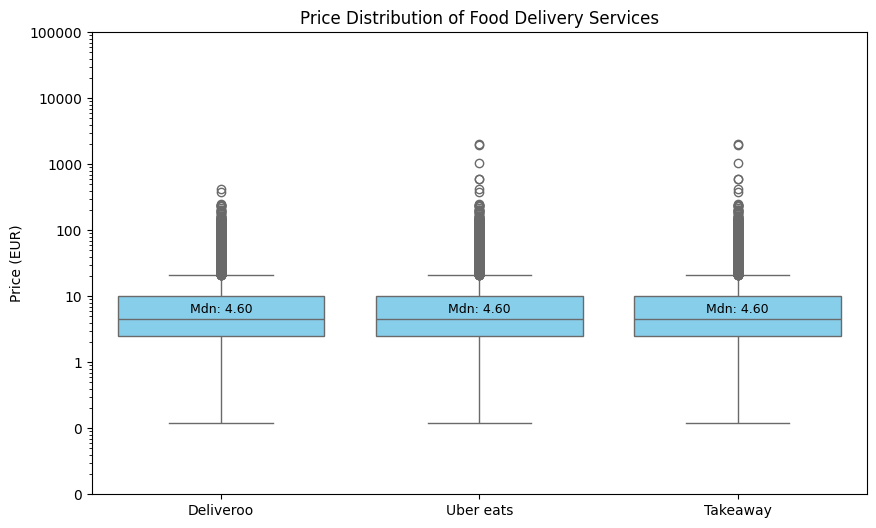

In [11]:
## Q: What is the price distribution of menu items?

query4 = """
    -- Deliveroo
    SELECT
        price, 'Deliveroo' AS service
    FROM
        menu_items
    WHERE
        id NOT IN (1078983574, 297241847, 297241848, 1258473919, 987159854, 1272748371)     --- exclude prices in cents on id's
        AND price > 0.1

        
    UNION ALL

    
    -- Uber Eats
    SELECT
        price, 'Uber eats' AS service
    FROM
        menu_items
    WHERE
        price > 0.1

        
    UNION ALL

    
    -- Takeaway
    SELECT
        price, 'Takeaway' AS service
    FROM
        menu_items
    WHERE
        price > 0.1
    """

df = pd.read_sql_query(query4, conn)

# Create boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='service', y='price', data=df, hue='service', palette='Set3', boxprops=dict(facecolor='skyblue'))

# Add the median values as text
median_values = df.groupby('service')['price'].median()
for i, service in enumerate(df['service'].unique()):
    median_value = median_values[service]
    plt.text(i, median_value + 1, f'Mdn: {median_value:.2f}', ha='center', color='black', fontsize=9)

# Customize the plot
plt.title('Price Distribution of Food Delivery Services')
plt.ylabel('Price (EUR)')
plt.xlabel('')
plt.yscale('log')
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f'{int(x)}' for x in plt.gca().get_yticks()])
plt.ylim(bottom=0.01 )

plt.show()

In general prices are not higher than 150 EUR, with the outliers mostly being sushi, wine and combo deals.
For Uber Eats there's one outlier above this level (wine bottle), but for Deliveroo there are many more, mostly being wine bottles.
I suspect much more alcohol is being sold on this last platform since there seems to be no contol on the category it's being put in (for example, wine can be found in 'Dessert', 'Italian', 'Snacks', 'Chicken'... instead of 'Alcohol').

On the bottom side, all platforms have lots of zero-prices used to select options/flavour/extra's, so these were excluded from the boxplots.

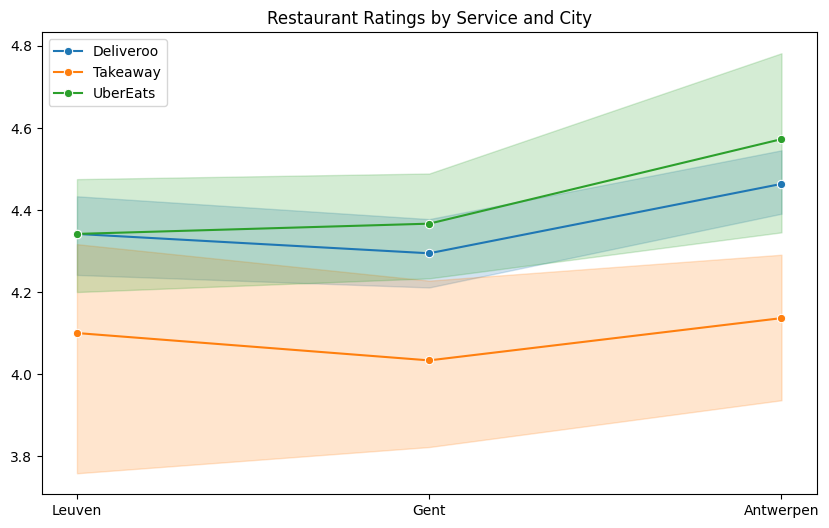

In [12]:
## Q: How do ratings of similar restaurants differ across Uber Eats, Deliveroo, and Takeaway?

# Make the query
query5 = """
    SELECT
        t.name, t.city, 
        d.rating AS Deliveroo, t.ratings AS Takeaway, u.rating__rating_value AS UberEats
    FROM
        takeaway_db.restaurants AS t
    INNER JOIN
        ubereats_db.restaurants AS u
        ON t.name = u.name AND t.postal_code = u.postal_code
    INNER JOIN
        restaurants AS d
        ON t.name = d.name AND t.postal_code = d.postal_code
    WHERE
        d.rating != 0.0 AND d.rating IS NOT NULL
        AND t.ratings != 0.0 AND t.ratings IS NOT NULL
        AND u.rating__rating_value != 0.0 AND u.rating__rating_value IS NOT NULL
        AND t.city IN ('Gent', 'Antwerpen', 'Leuven')
    ORDER BY
        Takeaway;
"""

# Load the query result into a DataFrame
df = pd.read_sql_query(query5, conn)

# Create lineplots
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='city', y='Deliveroo', label='Deliveroo', marker='o')
sns.lineplot(data=df, x='city', y='Takeaway', label='Takeaway', marker='o')
sns.lineplot(data=df, x='city', y='UberEats', label='UberEats', marker='o')

# Customize the plot
plt.title('Restaurant Ratings by Service and City')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.show()

When looking at these three cities with 11 to 18 restaurants using all three delivery services, it becomes clear that users of Takeaway tend to give lower ratings, 
and Uber Eats gets the highest.
It's also remarkable that voters on Deliveroo are much more likeminded than those on the other platforms.
In Leuven the average scores are closest to one another, and the people from Antwerp like to give higher scores; this seems to align with the cliché of them believing their city is the greatest on the planet.

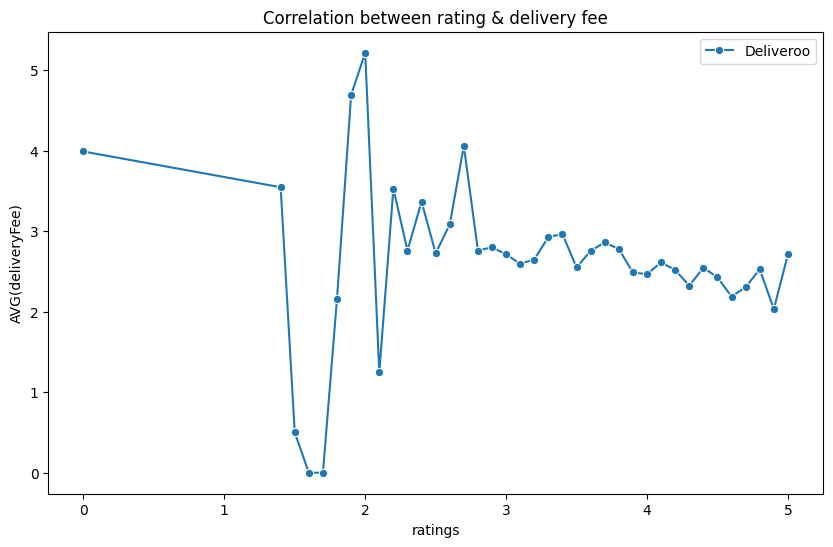

In [13]:
## Q: How do delivery fees vary across platforms and locations?

query_a = """
    SELECT
        t.city, t.deliveryFee, d.delivery_fee
    FROM
        takeaway_db.restaurants AS t
    INNER JOIN
        restaurants AS d
        ON t.name = d.name AND t.postal_code = d.postal_code
    ORDER BY
        t.city
"""

# Load the query result into a DataFrame
df = pd.read_sql_query(query_a, conn)

# Display the results
# display(df.head(10))


query_b = """
    SELECT
        AVG(deliveryFee), ratings
    FROM
        takeaway_db.restaurants
    GROUP BY
        ratings
    """
df_takeaway = pd.read_sql_query(query_b, conn)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_takeaway, x='ratings', y='AVG(deliveryFee)', label='Deliveroo', marker='o')
plt.title('Correlation between rating & delivery fee')
plt.show()

Uber Eats' website on delivery fees: "This fee varies based on your location. You pay less for nearby restaurants and you'll always know how much before selecting a restaurant."
This explains why there's no data on it in the database.

Deliveroo:
The standard delivery fee is 4.99 EUR. Out of the 318 restaurants I found working with both Deliveroo and Takeaway, only 5 had a different fee. Most of those are 0, situated in the vicinity of Brussels and Antwerp.

Takeaway:
There is a very extensive range of fees, indicating that restaurants themselves have the liberty of chosing it.
Only compared with rating, there is a clear and linear connection. Between ratings of 1.5 and 1.7 there is a huge dip, but this can be explained by the fact that there are only 4 entries for these values, and can therefore be ignored.

### Delivery services representation over belgium.

In [14]:
# Query the combined data
query1 = """
SELECT platform, COUNT(*) AS total_restaurants
FROM (
    SELECT 'Deliveroo' AS platform, name, city
    FROM restaurants
    UNION ALL
    SELECT 'UberEats' AS platform, name, city
    FROM ubereats_db.restaurants
    UNION ALL
    SELECT 'Takeaway' AS platform, name, city
    FROM takeaway_db.restaurants
)
GROUP BY platform;
"""

# query to find the cities where restaurant names occur in all three databases and count how many such restaurants exist for each city
query2 = """
SELECT d.city, COUNT(d.name) AS common_restaurant_count
FROM restaurants AS d
INNER JOIN ubereats_db.restaurants AS u 
    ON d.name = u.name AND d.city = u.city
INNER JOIN takeaway_db.restaurants AS t 
    ON d.name = t.name AND d.city = t.city
GROUP BY d.city
ORDER BY common_restaurant_count DESC;
"""

# Count Restaurants > 100 by City Per Platform
query3="""
SELECT 'Deliveroo' AS platform, city, COUNT(*) AS total_restaurants
FROM restaurants
GROUP BY city
HAVING COUNT(*) > 99
UNION ALL
SELECT 'UberEats' AS platform, city, COUNT(*) AS total_restaurants
FROM ubereats_db.restaurants
GROUP BY city
HAVING COUNT(*) > 99
UNION ALL
SELECT 'Takeaway' AS platform, city, COUNT(*) AS total_restaurants
FROM takeaway_db.restaurants
GROUP BY city
HAVING COUNT(*) > 99
ORDER BY total_restaurants DESC, city;
"""

query4_deliveroo="""
-- Deliveroo-exclusive restaurants
SELECT d.name AS restaurant_name, 'Deliveroo' AS platform
FROM restaurants AS d
WHERE NOT EXISTS (
    SELECT 1
    FROM ubereats_db.restaurants AS u
    WHERE u.name = d.name
)
AND NOT EXISTS (
    SELECT 1
    FROM takeaway_db.restaurants AS t
    WHERE t.name = d.name
);

"""

query4_ubereats="""
-- Uber Eats-exclusive restaurants
SELECT u.name AS restaurant_name, 'Ubereats' AS platform
FROM ubereats_db.restaurants AS u
WHERE NOT EXISTS (
    SELECT 1
    FROM restaurants AS d
    WHERE d.name = u.name
)
AND NOT EXISTS (
    SELECT 1
    FROM takeaway_db.restaurants AS t
    WHERE t.name = u.name
);
"""

query4_takeaway="""
-- TakeAway-exclusive restaurants
SELECT t.name AS restaurant_name, 'Takeaway' AS platform
FROM takeaway_db.restaurants AS t
WHERE NOT EXISTS (
    SELECT 1
    FROM restaurants AS d
    WHERE d.name = t.name
)
AND NOT EXISTS (
    SELECT 1
    FROM ubereats_db.restaurants AS u
    WHERE u.name = t.name
);
"""

In [15]:
# 1 Execute the query and load into pandas
restaurants_count = pd.read_sql_query(query1, conn)

# 2 Load the data into a Pandas DataFrame
restaurants_overlapping_3times = pd.read_sql_query(query2, conn)

# 3 Restaurants by City Per Platform
restaurants_by_city_per_platform = pd.read_sql_query(query3, conn)

# 4 Restaurants Exclusive to a Single Platform:
restaurant_excl_deliveroo = pd.read_sql_query(query4_deliveroo, conn)

restaurant_excl_ubereats =  pd.read_sql_query(query4_ubereats, conn)

restaurant_excl_takeaway =  pd.read_sql_query(query4_takeaway, conn)


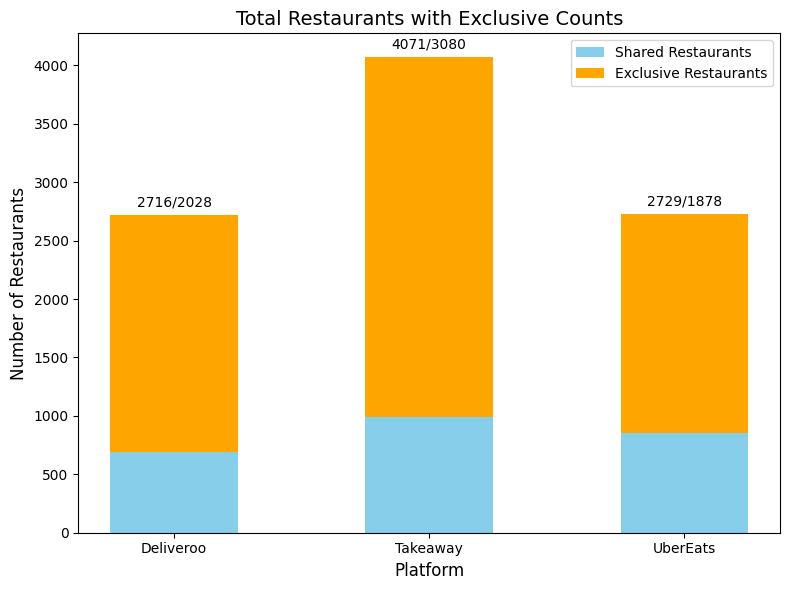

In [16]:
# Extract total restaurants dynamically
platforms = restaurants_count['platform'].tolist()
total_restaurants = restaurants_count['total_restaurants'].tolist()

# Extract exclusive restaurants dynamically
exclusive_restaurants = [
    len(restaurant_excl_deliveroo),
    len(restaurant_excl_takeaway),
    len(restaurant_excl_ubereats)
]

# Calculate shared restaurants dynamically
shared_restaurants = [t - e for t, e in zip(total_restaurants, exclusive_restaurants)]

# Bar Chart Design
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.5
x = range(len(platforms))

# Plot shared restaurants (bottom of bars)
ax.bar(x, shared_restaurants, bar_width, label='Shared Restaurants', color='skyblue')

# Plot exclusive restaurants (top of bars)
ax.bar(x, exclusive_restaurants, bar_width, bottom=shared_restaurants, label='Exclusive Restaurants', color='orange')

# Add labels to bars
for i in range(len(platforms)):
    ax.text(i, total_restaurants[i] + 50, f"{total_restaurants[i]}/{exclusive_restaurants[i]}", 
            ha='center', va='bottom', fontsize=10)

# Add titles and labels
ax.set_title("Total Restaurants with Exclusive Counts", fontsize=14)
ax.set_xlabel("Platform", fontsize=12)
ax.set_ylabel("Number of Restaurants", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(platforms)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

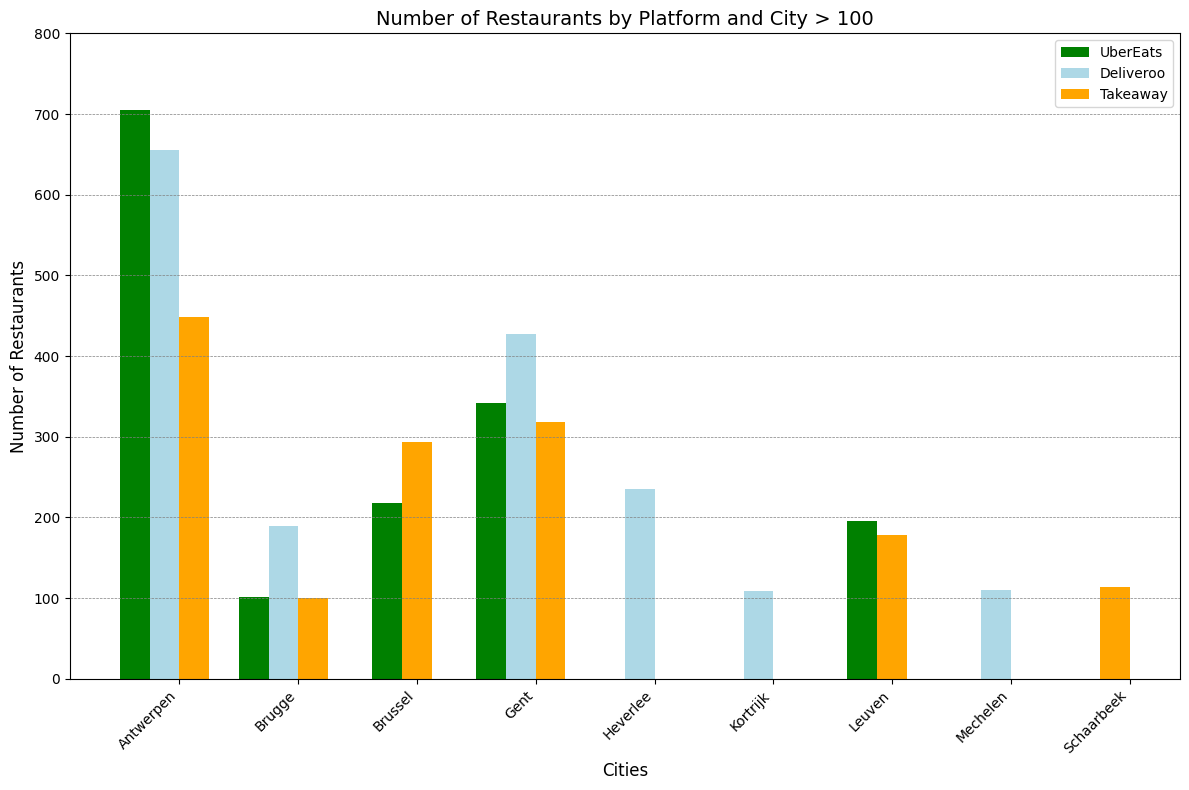

In [17]:
# Extract data
platforms = restaurants_by_city_per_platform['platform']
cities = restaurants_by_city_per_platform['city']
total_restaurants = restaurants_by_city_per_platform['total_restaurants']

# Pivot data to structure it for grouped bars
pivot_data = restaurants_by_city_per_platform.pivot(index='city', columns='platform', values='total_restaurants').fillna(0)

# Define the platforms and colors
platform_order = ['UberEats', 'Deliveroo', 'Takeaway']  # Ensure consistent order
colors = {'UberEats': 'green', 'Deliveroo': 'lightblue', 'Takeaway': 'orange'}

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25
x_positions = np.arange(len(pivot_data.index))  # Initial positions for cities

# Loop through cities and dynamically place bars
for city_idx, city in enumerate(pivot_data.index):
    # Dynamically select platforms with non-zero data
    platforms_present = [platform for platform in platform_order if pivot_data.loc[city, platform] > 0]
    num_platforms = len(platforms_present)
    
    # Dynamically position bars for the current city
    for i, platform in enumerate(platforms_present):
        ax.bar(
            x_positions[city_idx] + (i - num_platforms / 2) * bar_width,  # Center the bars for the city
            pivot_data.loc[city, platform],  # Height of the bar
            bar_width,
            label=platform if city_idx == 0 else None,  # Add label only once for the legend
            color=colors[platform]
        )

# Add dotted horizontal lines every 100 units
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
ax.set_yticks(range(0, int(pivot_data.max().max()) + 100, 100))  # Set ticks at intervals of 100

# Add labels and legend
ax.set_title("Number of Restaurants by Platform and City > 100", fontsize=14)
ax.set_xlabel("Cities", fontsize=12)
ax.set_ylabel("Number of Restaurants", fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

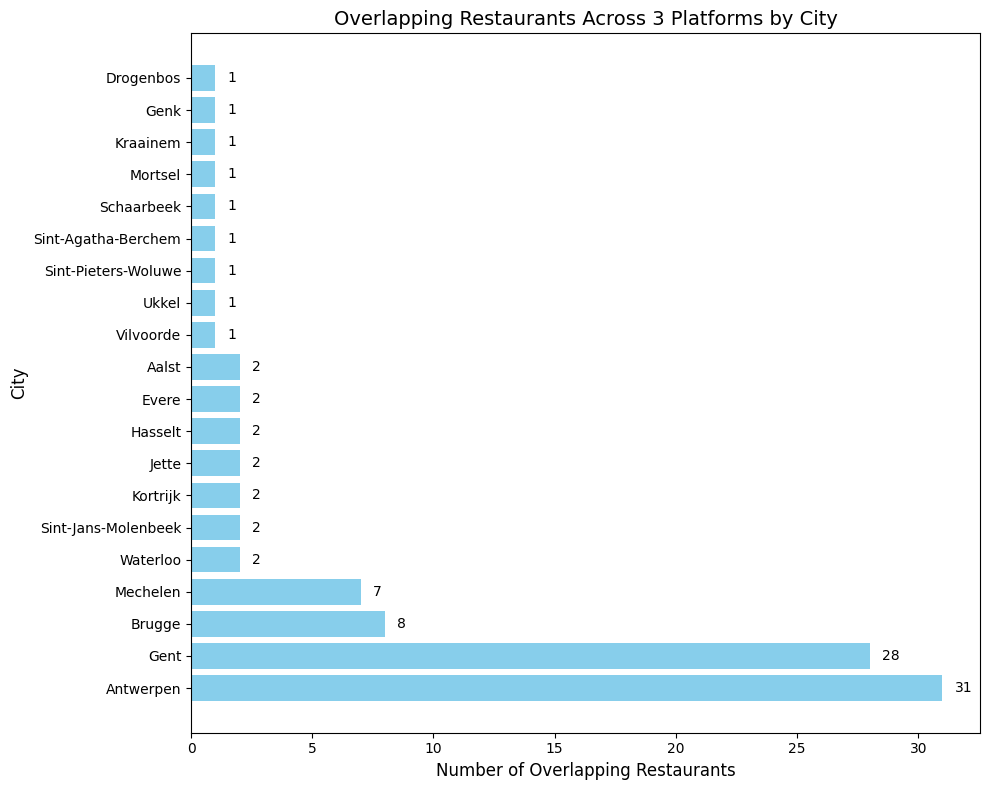

In [18]:
# Extract data
cities = restaurants_overlapping_3times['city']
common_counts = restaurants_overlapping_3times['common_restaurant_count']

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(cities, common_counts, color='skyblue')

# Add labels and title
ax.set_xlabel("Number of Overlapping Restaurants", fontsize=12)
ax.set_ylabel("City", fontsize=12)
ax.set_title("Overlapping Restaurants Across 3 Platforms by City", fontsize=14)

# Add values next to the bars
for i in range(len(common_counts)):
    ax.text(common_counts[i] + 0.5, i, str(common_counts[i]), va='center', fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()

### heatmap Average price of "Kapsalon" per platform per city

In [19]:
# Query to fetch the kapsalon data
query = """
SELECT 
    'Deliveroo' AS company,    
    'Kapsalon' AS menu_item_name,
    r.name AS restaurant_name,
    r.latitude AS latitude,
    r.longitude AS longitude,
    ROUND(AVG(m.price), 2) AS avg_kapsalon
FROM menu_items AS m
INNER JOIN restaurants AS r ON m.restaurant_id = r.id
WHERE m.name LIKE '%kapsalon%' AND m.price <> 0 AND m.price > 0
GROUP BY r.id, r.name, r.latitude, r.longitude, r.address, r.postal_code

UNION ALL

SELECT 
    'Uber Eats' AS company,    
    'Kapsalon' AS menu_item_name,
    r.name AS restaurant_name,
    r.latitude AS latitude,
    r.longitude AS longitude,
    ROUND(AVG(m.price), 2) AS avg_kapsalon
FROM ubereats_db.menu_items AS m
INNER JOIN ubereats_db.restaurants AS r ON m.restaurant_id = r.id
WHERE m.name LIKE '%kapsalon%' AND m.price <> 0 AND m.price > 0
GROUP BY r.id, r.name, r.latitude, r.longitude, r.address, r.postal_code

UNION ALL

SELECT 
    'Takeaway' AS company,    
    'Kapsalon' AS menu_item_name,
    r.name AS restaurant_name,
    r.latitude AS latitude,
    r.longitude AS longitude,
    ROUND(AVG(m.price), 2) AS avg_kapsalon
FROM takeaway_db.menuItems AS m
INNER JOIN takeaway_db.restaurants AS r ON m.primarySlug = r.primarySlug
WHERE m.name LIKE '%kapsalon%' AND m.price <> 0
GROUP BY r.primarySlug, r.name, r.latitude, r.longitude, r.address, r.city
ORDER BY avg_kapsalon;
"""

# Execute the query and load into a Pandas DataFrame
data = pd.read_sql_query(query, conn)

# Ensure latitude, longitude, and avg_kapsalon are floats
data['latitude'] = data['latitude'].astype(float)
data['longitude'] = data['longitude'].astype(float)
data['avg_kapsalon'] = data['avg_kapsalon'].astype(float)

# Normalize avg_kapsalon to a 0-1 scale
min_price = data['avg_kapsalon'].min()
max_price = data['avg_kapsalon'].max()
data['color'] = data['avg_kapsalon'].apply(lambda x: (x - min_price) / (max_price - min_price))
data['radius'] = data['avg_kapsalon'].apply(lambda x: (max_price - x) / (max_price - min_price) * 25 + 5)

# Create a base map centered on Belgium
m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)  # Centered on Belgium

# Create a colormap from green (low) to red (high)
cmap = colormaps['RdYlGn'].reversed()

# Add each restaurant as a circle marker
for index, row in data.iterrows():
    # Map normalized value to a color
    color = to_hex(cmap(row['color']))  # Convert RGBA to HEX
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['radius'],
        color=None,
        fill=True,
        fill_opacity=0.7,
        fill_color=color,
        popup=f"{row['restaurant_name']} - €{row['avg_kapsalon']}"
    ).add_to(m)

# Save the map
m.save("../assets/heatmaps/kapsalon_heatmap.html")
m

### Vegan representation 

#### Takeaway

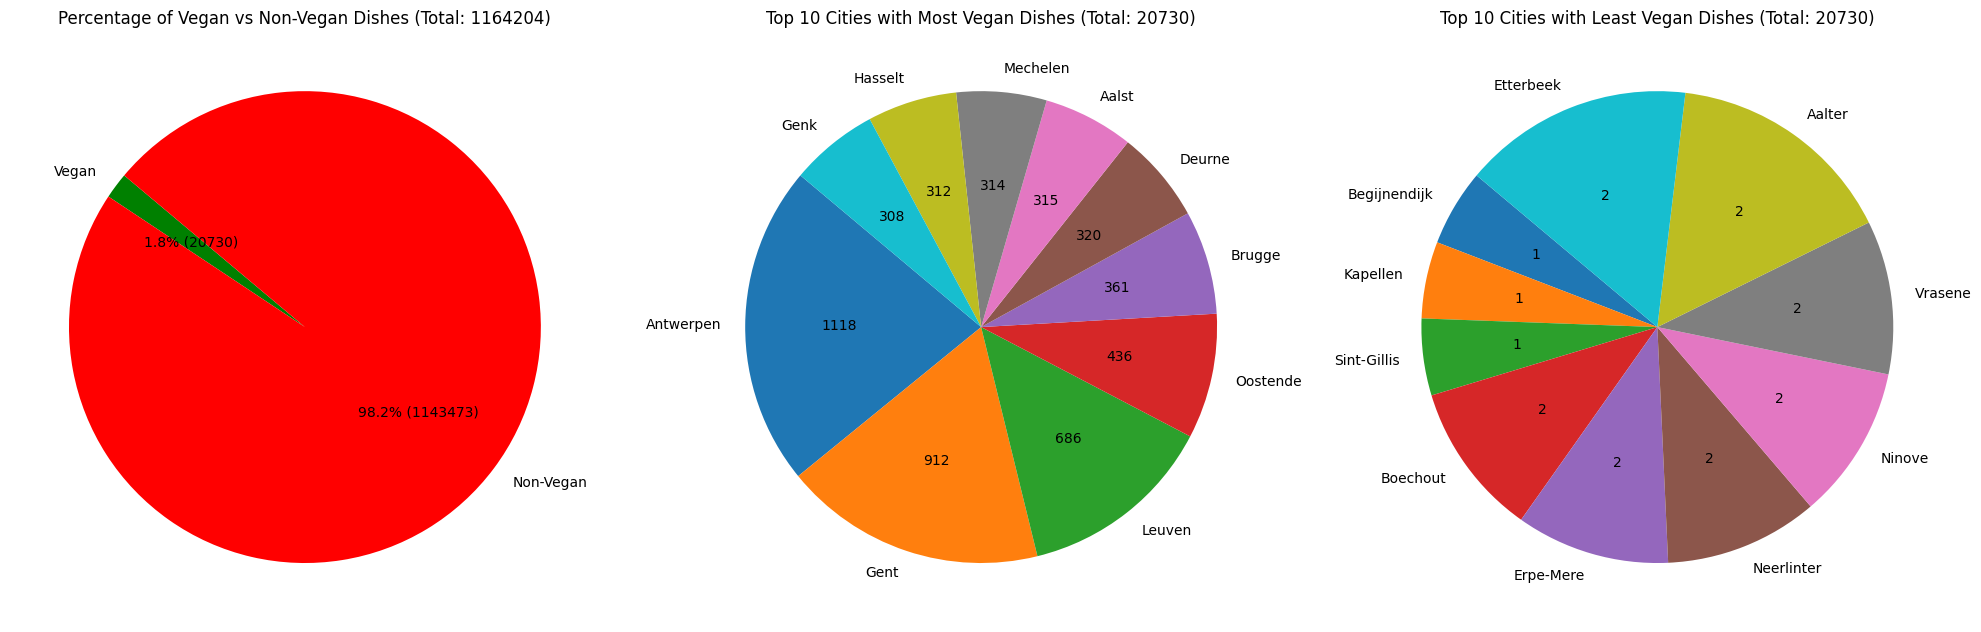

In [20]:
# SQL Query TAKEAWAY
takeaway_percentage_vegan = """
WITH item_counts AS (
    SELECT 
        SUM(CASE WHEN c.name LIKE '%Veg%' THEN 1 ELSE 0 END) AS vegan_count,
        SUM(CASE WHEN c.name NOT LIKE '%Veg%' THEN 1 ELSE 0 END) AS non_vegan_count
    FROM takeaway_db.menuItems AS mi
    INNER JOIN takeaway_db.categories AS c ON mi.id = c.item_id
    INNER JOIN takeaway_db.restaurants AS r ON mi.primarySlug = r.primarySlug
    WHERE mi.price > 0
)
SELECT 
    vegan_count,
    non_vegan_count,
    ROUND((vegan_count * 100.0) / (vegan_count + non_vegan_count), 2) AS vegan_percentage
FROM item_counts;
"""

top10_vegan_cities_max = """
SELECT 
    r.city AS city,
    COUNT(mi.id) AS vegan_dish_count
FROM takeaway_db.menuItems AS mi
INNER JOIN takeaway_db.restaurants AS r ON mi.primarySlug = r.primarySlug
INNER JOIN takeaway_db.categories AS c ON mi.id = c.item_id
WHERE c.name LIKE '%veg%'  -- Filters for vegan/vegetarian dishes
  AND mi.price > 0         -- Ensure only valid dishes with prices
GROUP BY r.city
ORDER BY vegan_dish_count DESC
LIMIT 10;
"""

top10_vegan_cities_min = """
SELECT 
    r.city AS city,
    COUNT(mi.id) AS vegan_dish_count
FROM takeaway_db.menuItems AS mi
INNER JOIN takeaway_db.restaurants AS r ON mi.primarySlug = r.primarySlug
INNER JOIN takeaway_db.categories AS c ON mi.id = c.item_id
WHERE c.name LIKE '%veg%'  -- Filters for vegan/vegetarian dishes
  AND mi.price > 0         -- Ensure only valid dishes with prices
GROUP BY r.city
ORDER BY vegan_dish_count ASC
LIMIT 10;
"""

# Execute query and fetch results
percentage_result = pd.read_sql_query(takeaway_percentage_vegan, conn)
best_vegan_dishes_by_city = pd.read_sql_query(top10_vegan_cities_max, conn)
worst_vegan_dishes_by_city = pd.read_sql_query(top10_vegan_cities_min, conn)

# Pie chart for percentage vegan vs non-vegan
labels_percentage = ['Vegan', 'Non-Vegan']
sizes_percentage = [
    percentage_result['vegan_count'].iloc[0],
    percentage_result['non_vegan_count'].iloc[0]
]

# Pie chart for top vegan cities
labels_max = best_vegan_dishes_by_city['city']
sizes_max = best_vegan_dishes_by_city['vegan_dish_count']

# Pie chart for bottom vegan cities
labels_min = worst_vegan_dishes_by_city['city']
sizes_min = worst_vegan_dishes_by_city['vegan_dish_count']

# Total vegan dishes
total_vegan_dishes = percentage_result['vegan_count'].iloc[0]

# Plot all pie charts
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Pie chart 1: Vegan vs Non-Vegan
total_dishes = sum(sizes_percentage)
axs[0].pie(
    sizes_percentage,
    labels=labels_percentage,
    autopct=lambda p: f'{p:.1f}% ({int(p * total_dishes / 100)})',
    colors=['green', 'red'],
    startangle=140
)
axs[0].set_title(f"Percentage of Vegan vs Non-Vegan Dishes (Total: {total_dishes})")

# Pie chart 2: Top Vegan Cities
total_vegan_top = sum(sizes_max)
axs[1].pie(
    sizes_max,
    labels=labels_max,
    autopct=lambda p: f'{int(p * total_vegan_top / 100)}',
    startangle=140
)
axs[1].set_title(f"Top 10 Cities with Most Vegan Dishes (Total: {total_vegan_dishes})")

# Pie chart 3: Bottom Vegan Cities
total_vegan_bottom = sum(sizes_min)
axs[2].pie(
    sizes_min,
    labels=labels_min,
    autopct=lambda p: f'{int(p * total_vegan_bottom / 100)}',
    startangle=140
)
axs[2].set_title(f"Top 10 Cities with Least Vegan Dishes (Total: {total_vegan_dishes})")

# Save and Show
plt.tight_layout()
plt.savefig("../assets/vegan_piecharts_takeaway.png")
plt.show()

#### Deliveroo

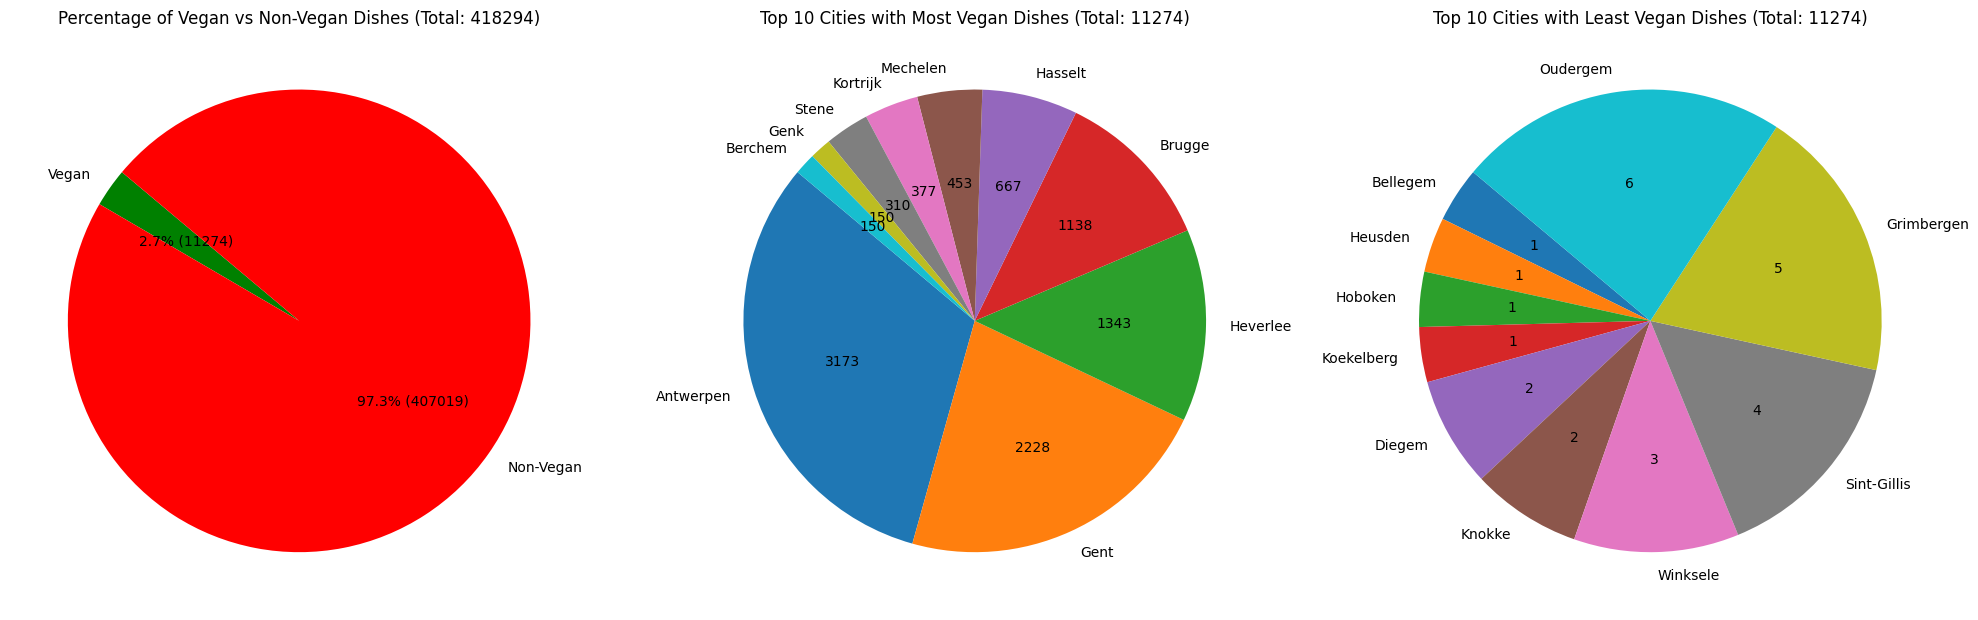

In [21]:
# SQL Query DELIVEROO
percentage_vegan = """
WITH item_counts AS (
    SELECT 
        SUM(CASE WHEN c.name LIKE '%Veg%' OR c.name LIKE '%veg%' OR mi.name LIKE '%Veg%' OR mi.name LIKE '%veg%' THEN 1 ELSE 0 END) AS vegan_count,
        SUM(CASE WHEN c.name NOT LIKE '%Veg%' OR c.name NOT LIKE '%veg%' OR mi.name NOT LIKE '%Veg%' OR mi.name NOT LIKE '%veg%' THEN 1 ELSE 0 END) AS non_vegan_count
    FROM categories AS c
        INNER JOIN menu_items AS mi ON c.categorie_id = mi.categorie_id
        INNER JOIN restaurants as r ON c.restaurant_id = r.id
    WHERE mi.price > 0
)
SELECT 
    vegan_count,
    non_vegan_count,
    ROUND((vegan_count * 100.0) / (vegan_count + non_vegan_count), 2) AS vegan_percentage
FROM item_counts;
"""

top10_vegan_cities_max = """
SELECT 
    r.city AS city,
    COUNT(mi.id) AS vegan_dish_count
FROM menu_items AS mi
INNER JOIN restaurants AS r ON mi.restaurant_id = r.id
INNER JOIN categories AS c ON mi.categorie_id = c.categorie_id
WHERE c.name LIKE '%Veg%' OR c.name LIKE '%veg%' OR mi.name LIKE '%Veg%' OR mi.name LIKE '%veg%'
  AND mi.price > 0
GROUP BY r.city
ORDER BY vegan_dish_count DESC
LIMIT 10;
"""

top10_vegan_cities_min = """
SELECT 
    r.city AS city,
    COUNT(mi.id) AS vegan_dish_count
FROM menu_items AS mi
INNER JOIN restaurants AS r ON mi.restaurant_id = r.id
INNER JOIN categories AS c ON mi.categorie_id = c.categorie_id
WHERE c.name LIKE '%Veg%' OR c.name LIKE '%veg%' OR mi.name LIKE '%Veg%' OR mi.name LIKE '%veg%'
  AND mi.price > 0
GROUP BY r.city
ORDER BY vegan_dish_count ASC
LIMIT 10;
"""

# Execute query and fetch results
percentage_result = pd.read_sql_query(percentage_vegan, conn)
best_vegan_dishes_by_city = pd.read_sql_query(top10_vegan_cities_max, conn)
worst_vegan_dishes_by_city = pd.read_sql_query(top10_vegan_cities_min, conn)

# Pie chart for percentage vegan vs non-vegan
labels_percentage = ['Vegan', 'Non-Vegan']
sizes_percentage = [
    percentage_result['vegan_count'].iloc[0],
    percentage_result['non_vegan_count'].iloc[0]
]

# Pie chart for top vegan cities
labels_max = best_vegan_dishes_by_city['city']
sizes_max = best_vegan_dishes_by_city['vegan_dish_count']

# Pie chart for bottom vegan cities
labels_min = worst_vegan_dishes_by_city['city']
sizes_min = worst_vegan_dishes_by_city['vegan_dish_count']

# Total vegan dishes
total_vegan_dishes = percentage_result['vegan_count'].iloc[0]

# Plot all pie charts
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Pie chart 1: Vegan vs Non-Vegan
total_dishes = sum(sizes_percentage)
axs[0].pie(
    sizes_percentage,
    labels=labels_percentage,
    autopct=lambda p: f'{p:.1f}% ({int(p * total_dishes / 100)})',
    colors=['green', 'red'],
    startangle=140
)
axs[0].set_title(f"Percentage of Vegan vs Non-Vegan Dishes (Total: {total_dishes})")

# Pie chart 2: Top Vegan Cities
total_vegan_top = sum(sizes_max)
axs[1].pie(
    sizes_max,
    labels=labels_max,
    autopct=lambda p: f'{int(p * total_vegan_top / 100)}',
    startangle=140
)
axs[1].set_title(f"Top 10 Cities with Most Vegan Dishes (Total: {total_vegan_dishes})")

# Pie chart 3: Bottom Vegan Cities
total_vegan_bottom = sum(sizes_min)
axs[2].pie(
    sizes_min,
    labels=labels_min,
    autopct=lambda p: f'{int(p * total_vegan_bottom / 100)}',
    startangle=140
)
axs[2].set_title(f"Top 10 Cities with Least Vegan Dishes (Total: {total_vegan_dishes})")

# Save and Show
plt.tight_layout()
plt.savefig("../assets/deliveroo_vegan_piecharts.png")
plt.show()

#### UberEats

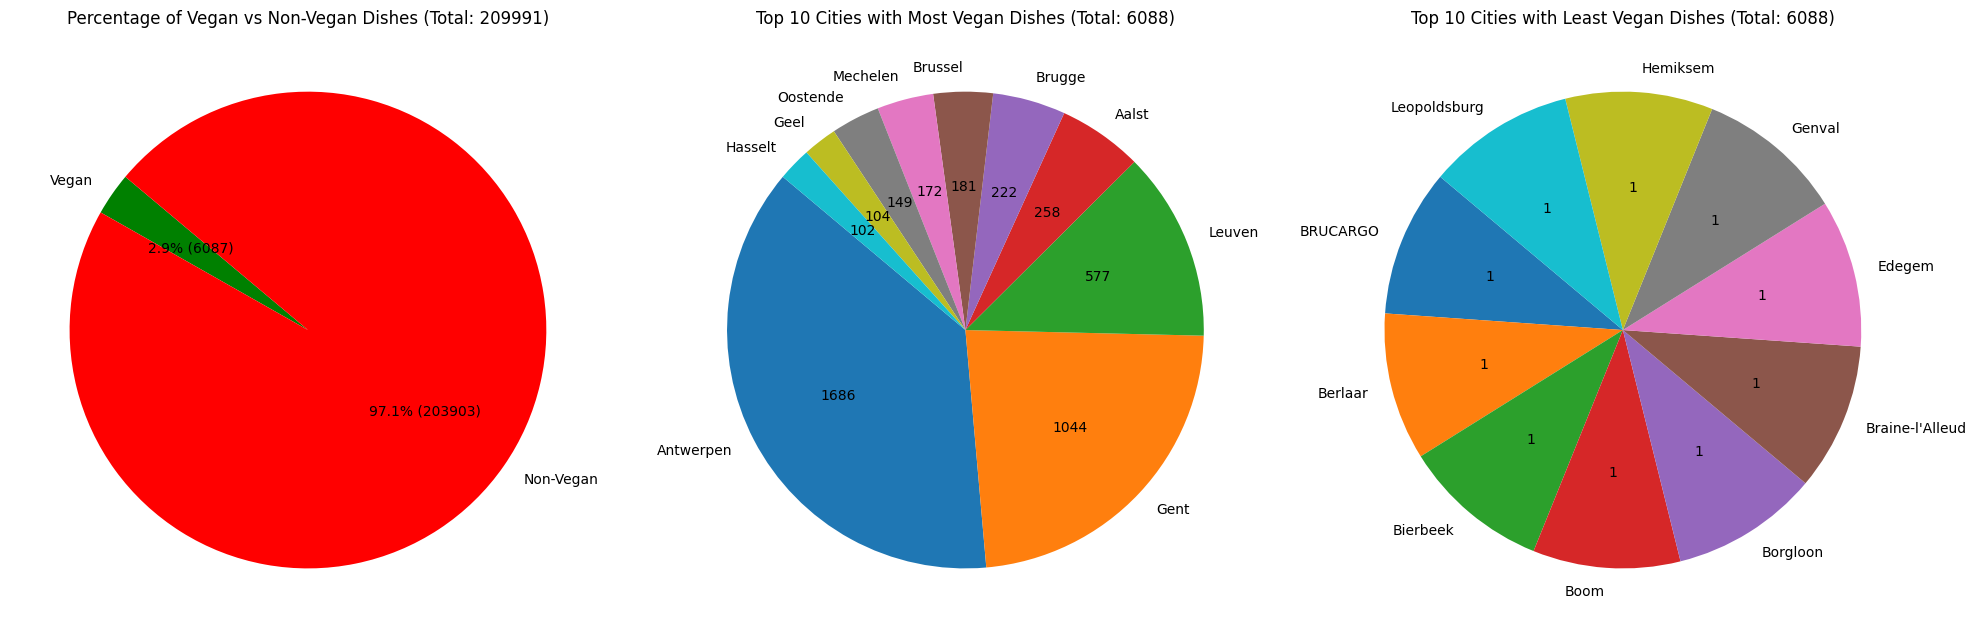

In [22]:
# SQL Query UberEats
percentage_vegan = """
WITH item_counts AS (
    SELECT 
        SUM(CASE WHEN mi.name LIKE '%Veg%' OR mi.name LIKE '%veg%' OR ms.title LIKE '%Veg%' OR ms.title LIKE '%veg%' THEN 1 END) AS vegan_count,
        SUM(CASE WHEN mi.name NOT LIKE '%Veg%' OR mi.name NOT LIKE '%veg%' OR ms.title NOT LIKE '%Veg%' OR ms.title NOT LIKE '%veg%' THEN 1 END) AS non_vegan_count
    FROM ubereats_db.menu_items AS mi
    INNER JOIN ubereats_db.menu_sections AS ms 
        ON mi.menu_section_id = ms.id
    INNER JOIN ubereats_db.restaurants AS r 
        ON mi.restaurant_id = r.id
    WHERE mi.price > 0
)
SELECT 
    vegan_count,
    non_vegan_count,
    ROUND((vegan_count * 100.0) / NULLIF((vegan_count + non_vegan_count), 0), 2) AS vegan_percentage
FROM item_counts;
"""

top10_vegan_cities_max = """
SELECT 
    r.city AS city,
    COUNT(mi.name) AS vegan_dish_count
FROM ubereats_db.menu_items AS mi
INNER JOIN ubereats_db.menu_sections AS ms ON mi.menu_section_id = ms.id
INNER JOIN ubereats_db.restaurants AS r ON mi.restaurant_id = r.id
WHERE (mi.name LIKE '%Veg%' OR mi.name LIKE '%veg%' OR ms.title LIKE '%Veg%' OR ms.title LIKE '%veg%')
    AND mi.price > 0
GROUP BY r.city
ORDER BY vegan_dish_count DESC
LIMIT 10;
"""

top10_vegan_cities_min = """
SELECT 
    r.city AS city,
    COUNT(mi.name) AS vegan_dish_count
FROM ubereats_db.menu_items AS mi
INNER JOIN ubereats_db.menu_sections AS ms ON mi.menu_section_id = ms.id
INNER JOIN ubereats_db.restaurants AS r ON mi.restaurant_id = r.id
WHERE (mi.name LIKE '%Veg%' OR mi.name LIKE '%veg%' OR ms.title LIKE '%Veg%' OR ms.title LIKE '%veg%')
    AND mi.price > 0
GROUP BY r.city
ORDER BY vegan_dish_count ASC
LIMIT 10;
"""

# Execute query and fetch results
percentage_result = pd.read_sql_query(percentage_vegan, conn)
best_vegan_dishes_by_city = pd.read_sql_query(top10_vegan_cities_max, conn)
worst_vegan_dishes_by_city = pd.read_sql_query(top10_vegan_cities_min, conn)

# Pie chart for percentage vegan vs non-vegan
labels_percentage = ['Vegan', 'Non-Vegan']
sizes_percentage = [
    percentage_result['vegan_count'].iloc[0],
    percentage_result['non_vegan_count'].iloc[0]
]

# Pie chart for top vegan cities
labels_max = best_vegan_dishes_by_city['city']
sizes_max = best_vegan_dishes_by_city['vegan_dish_count']

# Pie chart for bottom vegan cities
labels_min = worst_vegan_dishes_by_city['city']
sizes_min = worst_vegan_dishes_by_city['vegan_dish_count']

# Total vegan dishes
total_vegan_dishes = percentage_result['vegan_count'].iloc[0]

# Plot all pie charts
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Pie chart 1: Vegan vs Non-Vegan
total_dishes = sum(sizes_percentage)
axs[0].pie(
    sizes_percentage,
    labels=labels_percentage,
    autopct=lambda p: f'{p:.1f}% ({int(p * total_dishes / 100)})',
    colors=['green', 'red'],
    startangle=140
)
axs[0].set_title(f"Percentage of Vegan vs Non-Vegan Dishes (Total: {total_dishes})")

# Pie chart 2: Top Vegan Cities
total_vegan_top = sum(sizes_max)
axs[1].pie(
    sizes_max,
    labels=labels_max,
    autopct=lambda p: f'{int(p * total_vegan_top / 100)}',
    startangle=140
)
axs[1].set_title(f"Top 10 Cities with Most Vegan Dishes (Total: {total_vegan_dishes})")

# Pie chart 3: Bottom Vegan Cities
total_vegan_bottom = sum(sizes_min)
axs[2].pie(
    sizes_min,
    labels=labels_min,
    autopct=lambda p: f'{int(p * total_vegan_bottom / 100)}',
    startangle=140
)
axs[2].set_title(f"Top 10 Cities with Least Vegan Dishes (Total: {total_vegan_dishes})")

# Save and Show
plt.tight_layout()
plt.savefig("../assets/ubereats_vegan_piecharts.png")
plt.show()

In [23]:
# Detach the databases
conn.execute("DETACH DATABASE ubereats_db;")
conn.execute("DETACH DATABASE takeaway_db;")

# Close the connection
conn.close()